<a href="https://colab.research.google.com/github/lonespear/aerogel/blob/main/fiberL_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install medpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 13.5 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.2-cp310-cp310-linux_x86_64.whl size=762836 sha256=a69e02835e79cedde941ae3330f7a154645be17ea161bf5e487955227d887656
  Stored in directory: /root/.cache/pip/wheels/a1/b8/63/bdf557940ec60d1b8822e73ff9fbe7727ac19f009d46b5d175
Successfully built medpy


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from skimage.morphology import skeletonize
from medpy.filter.smoothing import anisotropic_diffusion
from scipy.spatial import cKDTree
import random
import requests

def iterative_prune(skel_img, size):
    """Iteratively remove endpoints (tips) from a skeletonized image."""
    def find_tips(skel_img):
        kernel = np.array([[1, 1, 1], [1, 10, 1], [1, 1, 1]], dtype=np.uint8)
        neighbors = cv2.filter2D(skel_img, -1, kernel)
        tips = (neighbors == 11).astype(np.uint8) * 255
        return tips

    pruned_img = skel_img.copy()
    for _ in range(size):
        endpoints = find_tips(pruned_img)
        pruned_img = cv2.subtract(pruned_img, endpoints)

    return pruned_img

def fast_prune(skel_img, size=5):
    pruned_img = skel_img.copy()
    contours, _ = cv2.findContours(skel_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    kept_segments = []

    for contour in contours:
        arc_length = cv2.arcLength(contour, closed=False)
        if arc_length > size:  # Keep contours with sufficient arc length
            kept_segments.append(contour)
        else:
            for point in contour:
                pruned_img[point[0][1], point[0][0]] = 0

    pruned_img = iterative_prune(pruned_img, size)
    return pruned_img, kept_segments

def find_branch_points(skel_img):
    """Identify branch points in a skeletonized image.

    Inputs:
    - skel_img: Binary skeletonized image (0 and 255 values).

    Returns:
    - branch_pts_img: Binary image with branch points marked as 255, rest as 0.
    """
    # Define the branch point detection kernels
    t1 = np.array([[-1, 1, -1],
                   [1, 1, 1],
                   [-1, -1, -1]])
    t2 = np.array([[1, -1, 1],
                   [-1, 1, -1],
                   [1, -1, -1]])
    y1 = np.array([[1, -1, 1],
                   [0, 1, 0],
                   [0, 1, 0]])
    y2 = np.array([[-1, 1, -1],
                   [1, 1, 0],
                   [-1, 0, 1]])

    # Rotate the kernels to cover all orientations
    kernels = [t1, t2, y1, y2]
    for _ in range(3):
        kernels += [np.rot90(kernel) for kernel in kernels[-4:]]

    # Create an empty image to store branch points
    branch_pts_img = np.zeros(skel_img.shape, dtype=np.uint8)

    # Apply each kernel with morphological hit-or-miss operation
    for kernel in kernels:
        hit_miss = cv2.morphologyEx(skel_img, cv2.MORPH_HITMISS, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=0)
        branch_pts_img = cv2.bitwise_or(branch_pts_img, hit_miss)

    return branch_pts_img

def calculate_intersection_associations(br_pts, edge_points_list, threshold=5):
    intersection_associations = {}
    br_pts_array = np.array(br_pts)
    all_edge_points = []
    edge_indices = []
    for edge_index, edge_points in enumerate(edge_points_list):
        all_edge_points.extend(edge_points)
        edge_indices.extend([edge_index] * len(edge_points))
    all_edge_points = np.array(all_edge_points)
    edge_indices = np.array(edge_indices)
    edge_tree = cKDTree(all_edge_points)

    for br_index, br_point in enumerate(br_pts_array):
        nearby_points = edge_tree.query_ball_point(br_point, threshold)
        if nearby_points:
            unique_edges = edge_indices[nearby_points]
            intersection_associations[br_index] = unique_edges.tolist()
    return intersection_associations

def sort_by_proximity(edge_points):
    sorted_points = [edge_points[0]]  # Start with the first point
    edge_points = edge_points[1:]    # Remove it from the list
    while len(edge_points) > 0:
        # Find the nearest point to the last point in sorted_points
        last_point = sorted_points[-1]
        distances = np.linalg.norm(edge_points - last_point, axis=1)
        nearest_idx = np.argmin(distances)
        sorted_points.append(edge_points[nearest_idx])
        edge_points = np.delete(edge_points, nearest_idx, axis=0)
    return np.array(sorted_points)

def draw_edge_objects(edge_objects, image_shape, thickness=1):
    color_image = np.zeros((image_shape[0], image_shape[1], 3), dtype=np.uint8)
    for edge in edge_objects:
        color = [random.randint(0, 255) for _ in range(3)]
        cv2.drawContours(color_image, [edge], -1, color, thickness=thickness, lineType=cv2.LINE_AA)
    return color_image

# Combined Density Plot and Histogram
def plot_density_histogram(data, ax):
    sns.histplot(data, bins=20, ax=ax, kde=True, color='steelblue', edgecolor='black')
    ax.set_title("Density and Histogram of Arc Lengths")
    ax.set_xlabel("Arc Length")
    ax.set_ylabel("Density / Frequency")

# Boxplot
def plot_boxplot(data, ax):
    sns.boxplot(data=data, ax=ax, color='lightblue')
    ax.set_title("Boxplot of Arc Lengths")
    ax.set_xlabel("Arc Length")

# Updated Visualization
def visualize_results(fib_image, skeletonized_img1, blurred_img, color_image, arc_lengths):
    fig, axes = plt.subplots(3, 2, figsize=(12, 12), constrained_layout=True)

    # Plot Original Image
    axes[0, 0].imshow(fib_image, cmap='gray')
    axes[0, 0].set_title("Original Image")

    # Plot Skeletonized Image
    axes[0, 1].imshow(skeletonized_img1, cmap='gray')
    axes[0, 1].set_title("Skeletonized Image (Linewidth Approx.)")

    # Plot Blurred Image
    axes[1, 0].imshow(blurred_img, cmap='gray')
    axes[1, 0].set_title("Blurred Image")

    # Plot Final Colored Image
    axes[1, 1].imshow(color_image)
    axes[1, 1].set_title("Final Colored Edge Network")

    # Combined Density and Histogram Plot
    plot_density_histogram(arc_lengths, axes[2, 0])

    # Boxplot
    plot_boxplot(arc_lengths, axes[2, 1])

    # Hide unused axes (if any)
    for ax in axes.flatten():
        ax.axis('on')  # Ensure all axes are turned on
    plt.show()

def proc_img(image_data, dim=1600):
    # Decode the image and convert it to grayscale
    og_img = cv2.imdecode(image_data, cv2.IMREAD_GRAYSCALE)
    # Snip off the dataribbon (later will need the dataribbon to identify scale for fiber length)
    fib_image = og_img[:3750,:]
    # Square cutout for processing (doesn't have to be square is my hunch)
    fib_image = fib_image[0:dim,0:dim]
    # Anisotropic diffusion first to adaptively eliminate noise while maintaining edge information
    diff_img = anisotropic_diffusion(fib_image, niter=50, kappa=20, gamma=0.1, option=1)
    # Initial thresholding cutoff in preparation for skeletonization, the second parameter will increase/decrease sensitivity
    _, thresholded_img = cv2.threshold(diff_img, 127, 255, 0)

    # Main loop for initial pass at skeletonization
    skel = np.zeros(thresholded_img.shape, np.uint8)                              # Creates blank canvas to store skeletonized image
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))                  # Generates kernel to pass through each section of image
    while True:
        open_img = cv2.morphologyEx(thresholded_img, cv2.MORPH_OPEN, element)     # Fit open-cross kernel to thresholded image
        temp = cv2.subtract(thresholded_img, open_img)                            # Subtracts the above from the original image
        temp = temp.astype(skel.dtype)                                            # Convert temp from 32-bit to 8bit datatype
        skel = cv2.bitwise_or(skel, temp)                                         # aggregates and compares both original and above created image
        thresholded_img = cv2.erode(thresholded_img, element)                     # degrades the width of the image by 1 pixel
        if cv2.countNonZero(thresholded_img) == 0:                                # conditional exits if there are no more remaining iterations to pass through
            break
    skeletonized_img1 = skel.copy()

    # Gaussian blur using 25x25 kernel
    blurred_img = cv2.GaussianBlur(skel, (25, 25), 0)
    # Very light noise removal (using 15 instead of 127 above here)
    _, bin_img = cv2.threshold(blurred_img, 15, 255, cv2.THRESH_BINARY)
    # Use standard skeletonization from cv2 package and convert final image output.
    skeletonized_img2 = skeletonize(bin_img // 255).astype(np.uint8) * 255

    # Segmentation function that also will remove identified objects less than size specified.
    pruned_skel, edge_objects = fast_prune(skeletonized_img2)

    branch_pts_img = find_branch_points(pruned_skel)
    branch_pts = np.argwhere(branch_pts_img != 0)
    # Create a kernel for dilation (3x3 kernel in this example, adjust as needed)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # Apply dilation using the kernel
    bp = cv2.dilate(branch_pts_img, kernel, iterations=1)

    # Subtract from the skeleton so that leaves are no longer connected
    segments = cv2.subtract(pruned_skel, bp)

    # Gather contours of leaves
    segment_objects, _ = cv2.findContours(np.copy(segments), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[-2:]

    branch_pts = np.array([[pt[1], pt[0]] for pt in branch_pts])  # Convert from [y, x]
    edge_points_list = [np.array([point[0] for point in edge]) for edge in segment_objects]

    intersection_associations = calculate_intersection_associations(branch_pts, edge_points_list, threshold=3)

    branch_connections = {}
    insufficient_points_count = 0

    for br_index, br_point in enumerate(branch_pts):
        br_point_array = br_point.reshape(1, -1)
        associated_edges = intersection_associations.get(br_index, [])
        edge_vectors = []
        for edge_index in associated_edges:
            edge_points = edge_points_list[edge_index]
            distances = np.linalg.norm(edge_points - br_point_array, axis=1)
            closest_indices = np.argsort(distances)[:2]
            closest_points = edge_points[closest_indices]
            if closest_points.shape[0] >= 2:
                vector = closest_points[1] - closest_points[0]
                edge_vectors.append((edge_index, vector))
            else:
                insufficient_points_count += 1

        min_dot_product = float('inf')
        best_pair = None
        for i, (edge1, vec1) in enumerate(edge_vectors):
            for j in range(i + 1, len(edge_vectors)):
                edge2, vec2 = edge_vectors[j]
                vec1_norm = vec1 / np.linalg.norm(vec1) if np.linalg.norm(vec1) != 0 else vec1
                vec2_norm = vec2 / np.linalg.norm(vec2) if np.linalg.norm(vec2) != 0 else vec2
                dot_product = np.dot(vec1_norm, vec2_norm)
                if dot_product < min_dot_product:
                    min_dot_product = dot_product
                    best_pair = (edge1, edge2)

        if best_pair:
            branch_connections[br_index] = best_pair

    # Create connected groups using a dictionary to track connected edges
    connected_groups = {}
    for edges in branch_connections.values():
        i, j = edges
        group_i = next((group for group in connected_groups.values() if i in group), None)
        group_j = next((group for group in connected_groups.values() if j in group), None)
        if group_i and group_j:
            if group_i != group_j:
                group_i.update(group_j)
                for k in group_j:
                    connected_groups[k] = group_i
        elif group_i:
            group_i.add(j)
            connected_groups[j] = group_i
        elif group_j:
            group_j.add(i)
            connected_groups[i] = group_j
        else:
            new_group = {i, j}
            connected_groups[i] = new_group
            connected_groups[j] = new_group

    # Get unique groups and ensure all edges are added
    unique_groups = {id(group): group for group in connected_groups.values()}.values()
    new_edge_objects = [np.concatenate([edge_points_list[idx] for idx in group], axis=0) for group in unique_groups]

    # Add any edges that weren't connected
    all_connected_indices = {idx for group in unique_groups for idx in group}
    for idx, edge in enumerate(edge_points_list):
        if idx not in all_connected_indices:
            new_edge_objects.append(edge)

    unique_groups = {id(group): group for group in connected_groups.values()}.values()
    new_edge_objects = [np.concatenate([edge_points_list[idx] for idx in group], axis=0) for group in unique_groups]
    all_connected_indices = {idx for group in unique_groups for idx in group}
    for idx, edge in enumerate(edge_points_list):
        if idx not in all_connected_indices:
            new_edge_objects.append(edge)

    sorted_edge_objects = [sort_by_proximity(edge) for edge in new_edge_objects]
    color_image = draw_edge_objects(sorted_edge_objects, image_shape=pruned_skel.shape, thickness=2)
    arc_lengths = [cv2.arcLength(edge, closed=False) for edge in new_edge_objects]

    visualize_results(
        fib_image=fib_image,
        skeletonized_img1=skeletonized_img1,
        blurred_img=blurred_img,
        color_image=color_image,
        arc_lengths=arc_lengths
    )

    print("Number of branch points:", len(branch_pts))
    print("Number of Intersection Associations:", len(intersection_associations))
    print("Number of Branch Connections: ", len(branch_connections))
    print("Average Fiber Length:", np.mean(arc_lengths))
    print("Insufficient Points Count:", insufficient_points_count)

    return pruned_skel, edge_objects, sorted_edge_objects, branch_pts, intersection_associations, branch_connections, color_image

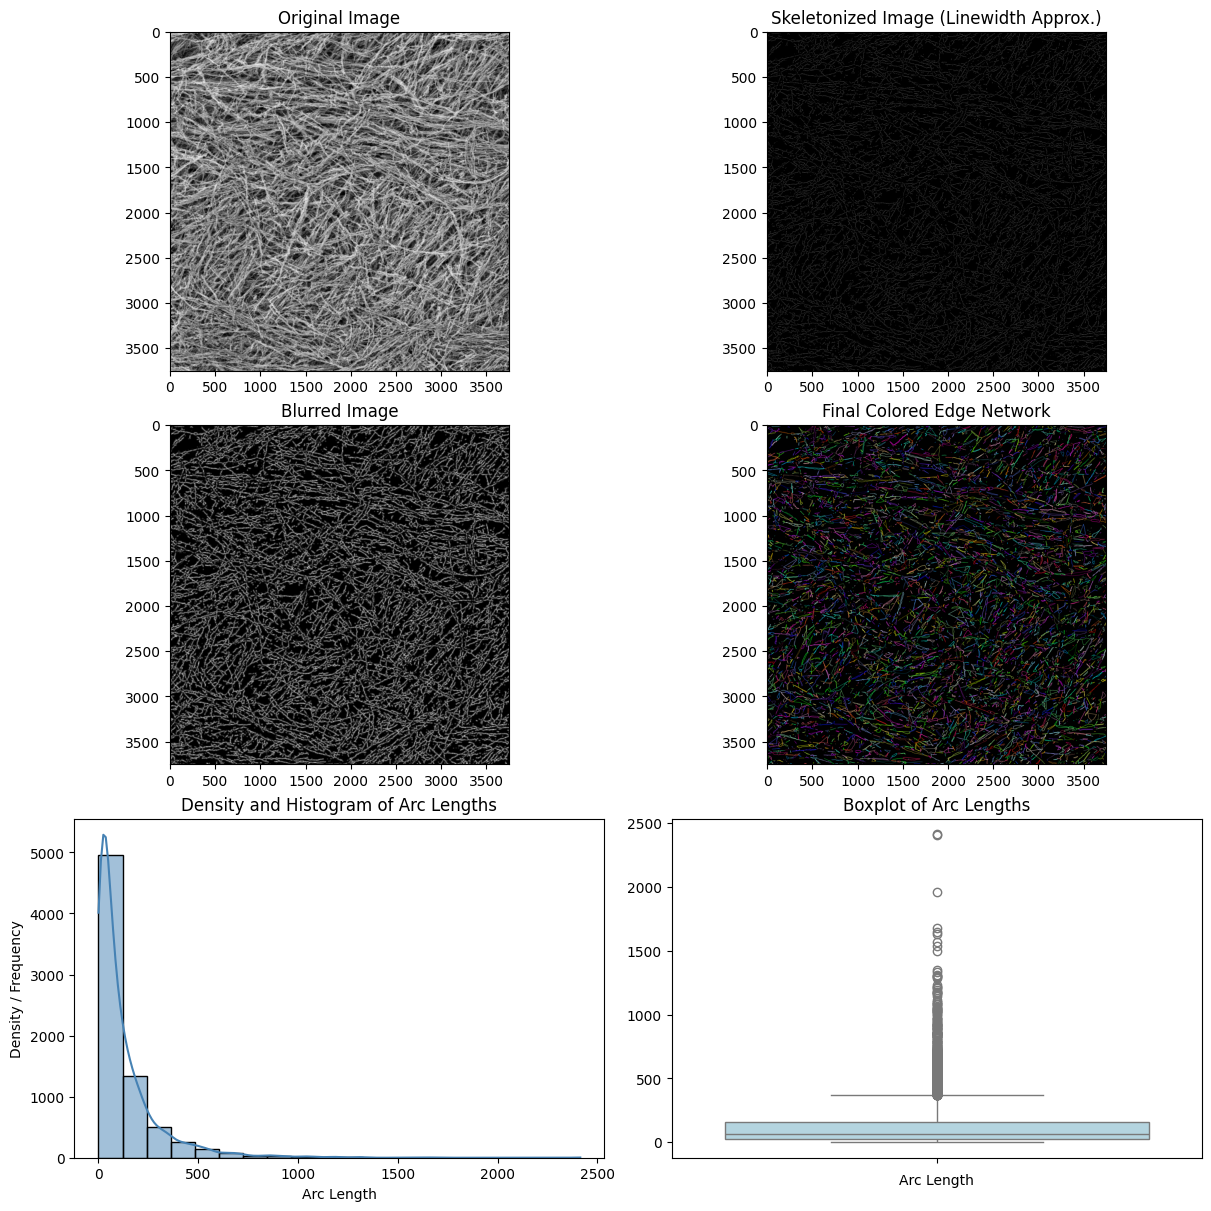

Number of branch points: 5702
Number of Intersection Associations: 5700
Number of Branch Connections:  5679
Average Fiber Length: 127.72291448524726
Insufficient Points Count: 273


In [17]:
# URL of the file
url = "https://github.com/lonespear/aerogel/raw/main/aerogel_co_50mM_magnet_0016.tif"
# Fetch the image from the URL and convert to numpy array
img_data = np.asarray(bytearray(requests.get(url).content), dtype="uint8")
pruned_skel, old_edge_objects, new_edge_objects, branch_pts, intersection_associations, branch_connections, color_image = proc_img(img_data, 3750)

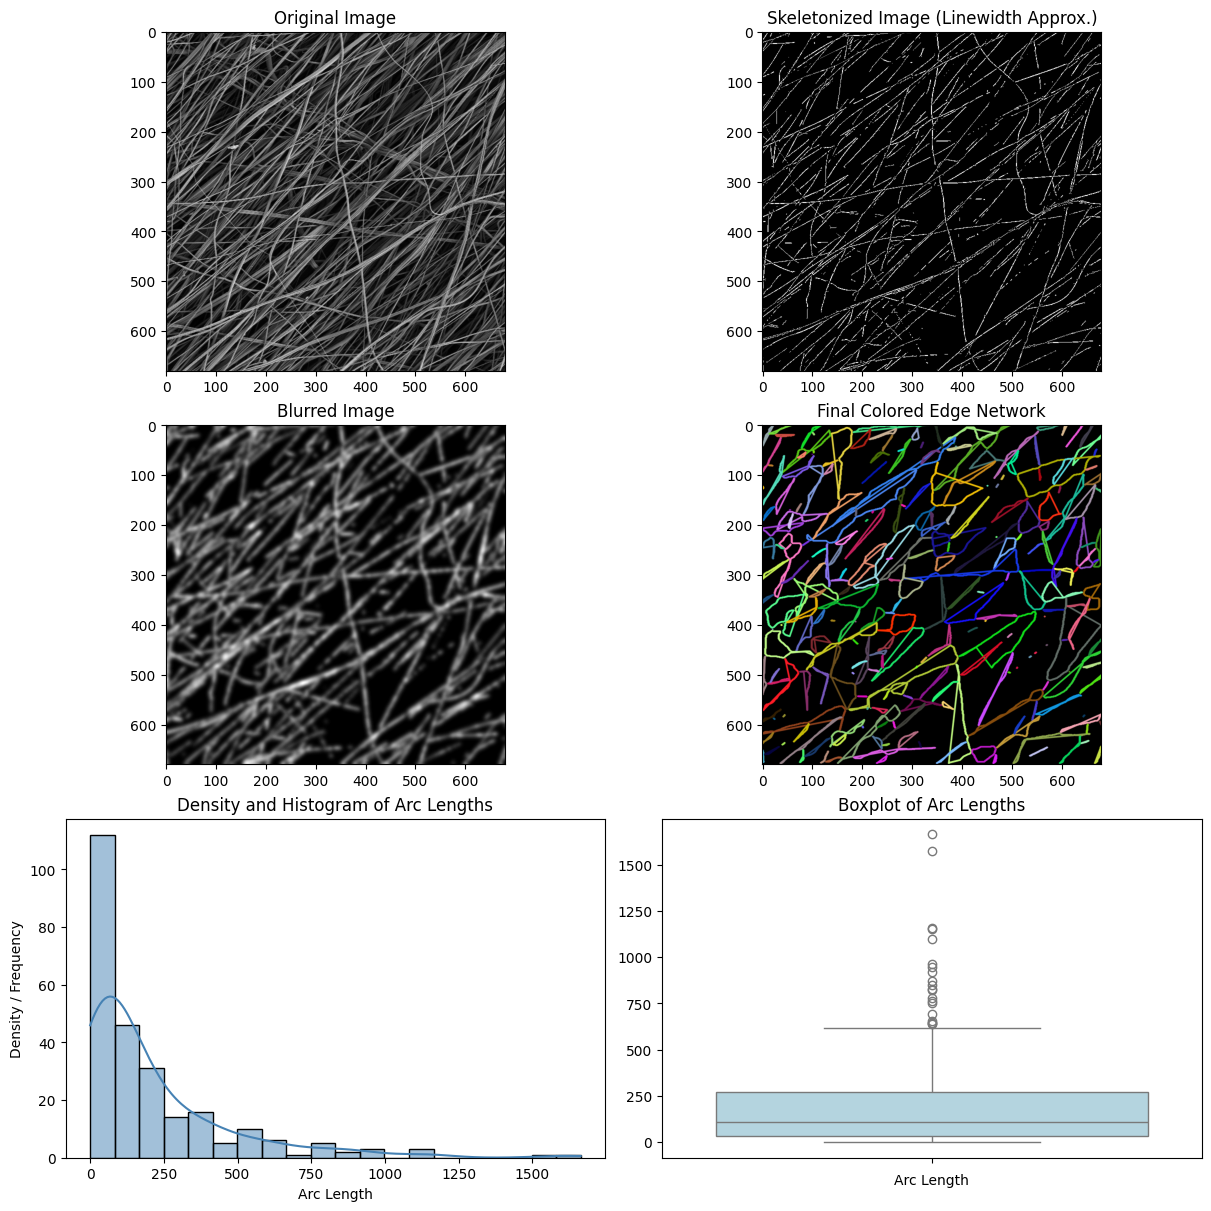

Number of branch points: 360
Number of Intersection Associations: 360
Number of Branch Connections:  354
Average Fiber Length: 207.26137769361958
Insufficient Points Count: 15


In [18]:
# URL of the file
url = "https://github.com/lonespear/aerogel/raw/main/highalign_PLCCLgel_500x_13.tif"
# Fetch the image from the URL and convert to numpy array
img_data = np.asarray(bytearray(requests.get(url).content), dtype="uint8")
pruned_skel, old_edge_objects,
new_edge_objects, branch_pts,
pruned_skel, old_edge_objects, new_edge_objects, branch_pts, intersection_associations, branch_connections, color_image = proc_img(img_data, 680)